In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray
from tqdm.notebook import tqdm
import pointpats
import seaborn as sns
%matplotlib inline

#### Set directory

In [2]:
os.chdir("/home/silva/Research/Alta-Floresta/")

### Importing dataset

In [3]:
dset = xarray.open_dataset('DATASETS/dset_AF_3.nc')
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 ...
    lat                    (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables: (12/14)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 ...
    eTh                    (y, x) float64 ...
    eU                     (y, x) float64 ...
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    litho_units            (y, x) object ...
    labels                 (y, x) float64 ...
    fav_lithos             (y, x) float64 ...
    dykes_buffer           (y, x) float64 ...
    lineam_ne_sw_proxim    (y, x) float64 ...
    lineam_wnw_ese_proxim  (y, x) float64 ...
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

#### Split area into training and test

In [4]:
ny, nx = dset.dims['y'], dset.dims['x']

In [5]:
lat_ths = -10.15
# filter locations where lat > ths
train_idk, train_idj = np.where(dset['lat'].data > lat_ths)
# filter locations where lat <= ths
test_idk, test_idj = np.where(dset['lat'].data <= lat_ths)

In [6]:
ny0, nx0 = np.unique(dset['lat'].data[train_idk, train_idj]).size, np.unique(dset['lon'].data[train_idk, train_idj]).size
print((ny0, nx0))
ny1, nx1 = np.unique(dset['lat'].data[test_idk, test_idj]).size, np.unique(dset['lon'].data[test_idk, test_idj]).size
print((ny1, nx1))

(581, 1322)
(754, 1322)


In [7]:
variables = [var for var in dset.data_vars]
print(variables)

['TC', 'Kperc', 'eTh', 'eU', 'resmag', 'asa', 'tilt', 'DTM', 'litho_units', 'labels', 'fav_lithos', 'dykes_buffer', 'lineam_ne_sw_proxim', 'lineam_wnw_ese_proxim']


#### Filter deposits and occurrences

In [8]:
cond = (dset['labels'].data == 1) | (dset['labels'].data == 2)

# positive locations' index
pk, pj = np.where(cond)

#### Point pattern analysis

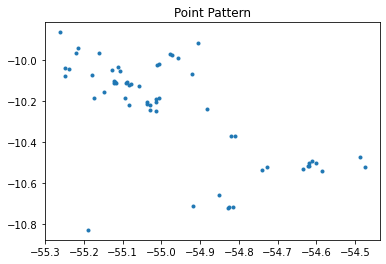

In [9]:
# positive locations' coordinates
p_lat, p_lon = dset['lat'].data[pk, pj], dset['lon'].data[pk, pj]

points = np.stack((p_lon, p_lat), axis=1)
pp = pointpats.PointPattern(points)
pp.plot()

[9.92491978] km


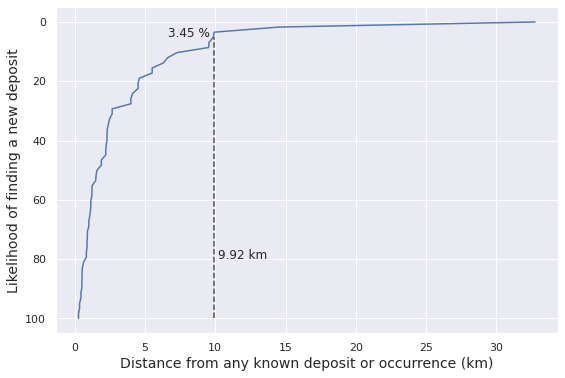

In [12]:
sns.set_theme()
distances = np.sort(pp.nnd*111, axis=0) # distances [km]
perc = np.linspace(0, 100, distances.size)[::-1]
# inflexion
infl = 56
print(distances[infl], 'km')

plt.figure(figsize=(9, 6), facecolor='w')

plt.plot(distances, perc, alpha=0.95)
plt.plot([distances[infl]]*len(perc[:infl]), perc[:infl], linestyle='--', color='.3')
#plt.scatter(distances[infl], perc[infl], color='.4')
plt.xlabel('Distance from any known deposit or occurrence (km)', fontsize=14)
plt.ylabel('Likelihood of finding a new deposit', fontsize=14)
plt.text(distances[infl]+0.3, 80, f'{distances[infl][0]:.2f} km')
plt.text(distances[infl]-3.3, perc[infl]+1.5, f'{perc[infl]:.2f} %')
plt.gca().invert_yaxis()
plt.savefig('figs/dep_prob_dists.png', dpi=400, bbox_inches='tight')
plt.show()

In [11]:
def calc_dist(ds, gdf, xdim='lon', ydim='lat', n=1000, set_random=True):

    import warnings
    from numpy.random import choice
    from numpy import concatenate
    from scipy.interpolate import griddata
    from scipy.spatial.distance import euclidean
    from tqdm.notebook import tqdm
    import time
    from sys import stdout
    warnings.simplefilter("ignore", UserWarning)
    
    tic = time.time()
    x = ds[xdim].data
    y = ds[ydim].data
    ny, nx = ds.dims['y'], ds.dims['x']
    print((ny, nx))
     

    if set_random:
        index = np.arange(0, y.size, 1, dtype=int)
        sy = sx = choice(index, size=int(n*.8), replace=False)
    
    else:
        sy = sx = np.arange(0, y.size, int(n*.8), dtype=int)
    
    yborder = np.linspace(0, ny-1, n//20, dtype=int)
    xborder = np.linspace(0, nx-1, n//20, dtype=int)
    xi = concatenate([x.ravel()[sx], x[0, :][xborder], x[-1, :][xborder],
                      x[:, 0][yborder], x[:,-1][yborder]])
    yi = concatenate([y.ravel()[sy], y[0, :][xborder], y[-1, :][xborder],
                      y[:, 0][yborder], y[:, -1][yborder]])
    
    # create buffer array
    buffer = np.empty(xi.size)
    
    # gdf x, y coordinates
    xp = gdf.geometry.x.values
    yp = gdf.geometry.y.values
    
    c = 0
    for x_i, y_i in zip(xi, yi):
        
        percentage = c/n
        time_msg = "\rRunning Progress at {0:.0%} ".format(percentage)
        stdout.write(time_msg)
        # store distances
        dist = []
        for x_p, y_p in zip(xp, yp):
    
            dist.append(euclidean((x_i, y_i), (x_p, y_p)))
        
        # add min distance to array
        buffer[c] = np.min(dist)
        c += 1
    
    # interp
    buffer = griddata((xi, yi), buffer, (x, y), method='linear')
    buffer = np.nan_to_num(buffer, nan=np.nanmean(buffer))
    toc = time.time()
    
    print(f'\n Processing Time: {(toc-tic)/60} min.')
    return buffer

In [14]:
from shapely import geometry
# EPSG:4674
crs = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"

pos_gdf = pd.DataFrame({'lon':p_lon, 'lat':p_lat})
# create geodataframe
pos_gdf['geometry'] = gpd.points_from_xy(pos_gdf.lon, pos_gdf.lat)
pos_gdf = gpd.GeoDataFrame(pos_gdf, geometry='geometry', crs=crs)
pos_gdf.head()

,lon,lat,geometry
0,-55.189292,-10.828842,POINT (-55.18929 -10.82884)
1,-54.827774,-10.719615,POINT (-54.82777 -10.71961)
2,-54.824395,-10.717363,POINT (-54.82440 -10.71736)
3,-54.814259,-10.717363,POINT (-54.81426 -10.71736)
4,-54.918998,-10.710607,POINT (-54.91900 -10.71061)


In [15]:
# export positive locations
pos_gdf.to_file('VETORES/positive_loc.gpkg', 'GPKG')

/home/silva/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [16]:
buffer_pos = calc_dist(dset, pos_gdf, n=50000)*111

(1335, 1322)
Running Progress at 100% 
 Processing Time: 0.2557573914527893 min.


In [17]:
dset['pos_locations_buffer'] =  (['y', 'x'], buffer_pos, {'variable':'Proximity to positive locations', 'unit':'km'})
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 -55.49 -55.49 -55.49 ... -54.0 -54.0
    lat                    (y, x) float64 -11.0 -11.0 -11.0 ... -9.497 -9.497
Dimensions without coordinates: y, x
Data variables: (12/15)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 ...
    eTh                    (y, x) float64 ...
    eU                     (y, x) float64 ...
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    labels                 (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fav_lithos             (y, x) float64 ...
    dykes_buffer           (y, x) float64 ...
    lineam_ne_sw_proxim    (y, x) float64 ...
    lineam_wnw_ese_proxim  (y, x) float64 ...
    pos_locations_buffer   (y, x) float64 38.24 38.13 38.02 ... 110.3 110.5
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

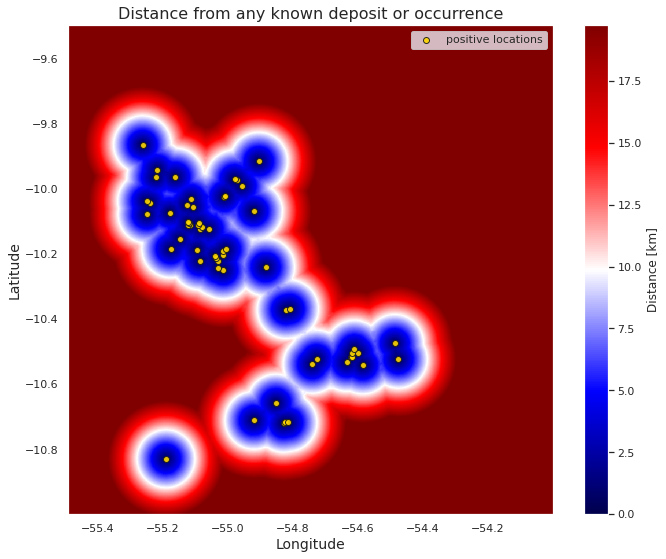

In [18]:
plt.rcParams['axes.grid'] = False
fig, ax = plt.subplots(figsize=(11, 9))
cat = np.where(dset['pos_locations_buffer'].data < distances[infl][0], 1, 0)
im = ax.pcolormesh(dset['lon'].data, dset['lat'].data, dset['pos_locations_buffer'].data,
                   shading='auto', cmap='seismic', vmin=0., vmax=np.max(distances)-13)
pos_gdf.plot(ax=ax, color='gold', edgecolor='k', alpha=0.9, label='positive locations')
plt.colorbar(im, ax=ax, label='Distance [km]')
ax.set_title('Distance from any known deposit or occurrence', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_aspect(1)
plt.legend()
plt.savefig('figs/pos_buffer_map.png', dpi=400, bbox_inches='tight')
plt.show()

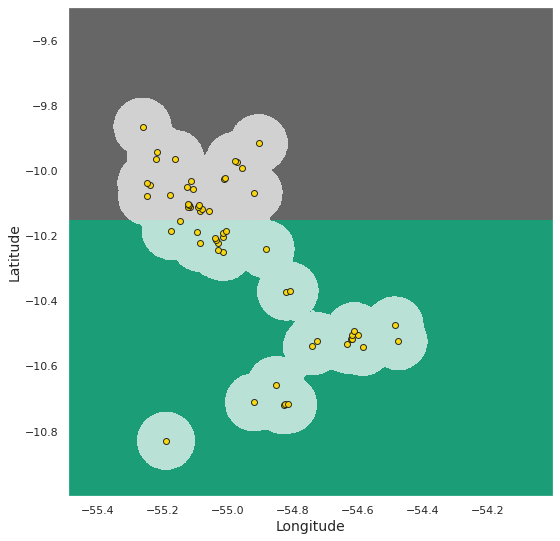

In [27]:
fig, ax = plt.subplots(figsize=(9, 9))
train_test_area = np.where(dset['lat'].data > lat_ths, 1, 0)
cat = np.where(dset['pos_locations_buffer'].data < distances[infl][0], 1, np.nan)
im = ax.pcolormesh(dset['lon'].data, dset['lat'].data, train_test_area,
                   shading='auto', cmap='Dark2')
im = ax.pcolormesh(dset['lon'].data, dset['lat'].data, cat,
                   shading='auto', cmap='Greys', alpha=0.7)
pos_gdf.plot(ax=ax, color='gold', edgecolor='k', alpha=0.9, label='positive locations')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_aspect(1)
#plt.legend()
plt.savefig('figs/train_test_areas.png', dpi=400, bbox_inches='tight')
# plt.savefig('figs/train_test_areas.svg', format='svg', dpi=400, bbox_inches='tight')
plt.show()

### Use litho-classes to select negative examples

In [18]:
lithos = gpd.read_file('Juruena_Teles_Pires_Mapa_Integrado/Litologia/Juruena_Teles_Pires_Lito.shp')
crs = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"
lithos.to_crs(crs, inplace=True)
lithos.head(3)

,COD_UNI_ES,SIGLA_UNID,NOME_UNIDA,SIGLAS_ANT,HIERARQUIA,IDADE_MAX,ERRO_MAX,EON_IDAD_M,ERA_MAXIMA,PERIODO_MA,...,ERRO_PRESS,TIPO_BARIC,TRAJETORIA,LITOTIPO1,LITOTIPO2,CLASSE_ROC,CLASSE_R_1,BB_SUBCLAS,BB_SUBCL_1,geometry
0,3207,MP2d2,Dardanelos - Fácies 2,None,Fácies,1400.0,0.0,Proterozóico,Mesoproterozóico,Ectasiano,...,None,None,None,None,"Arenito arcoseano, Arenito",None,Sedimentar,None,Clástica,"POLYGON ((-55.07166 -11.00000, -55.07169 -11.0..."
1,643,N1r,Ronuro,N1a,Formação,23.5,0.0,Fanerozóico,Cenozóico,Neogeno,...,None,None,None,None,"Cascalho, Argila, Areia",None,Material superficial,None,Sedimento inconsolidado,"POLYGON ((-54.23781 -10.72836, -54.23924 -10.7..."
2,1360,PP34mvbm,Complexo Nova Monte Verde - Unidade Bacaeri-Mogno,PP23bm,Unidade,2240.0,0.0,Proterozóico,Paleoproterozóico,Orosiriano,...,0,Média P/T,Não determinada,None,"Metachert, Paragnaisse, Rocha calcissilicática...",None,Metamórfica,None,Metamorfismo regional,"POLYGON ((-56.91694 -9.87497, -56.91692 -9.875..."


In [19]:
# check unique rock classes
classes = lithos.CLASSE_R_1.unique()
print(classes)

['Sedimentar' 'Material superficial' 'Metamórfica' 'Ígnea'
 'Metamórfica, Ígnea' 'Sedimentar, Ígnea' None
 'Material superficial, Sedimentar']


In [20]:
c1 = (lithos.CLASSE_R_1.values == 'Sedimentar')
c2 = (lithos.CLASSE_R_1.values == 'Material superficial') 
c3 = (lithos.CLASSE_R_1.values == 'Material superficial, Sedimentar')
lithos['rock_classes'] = np.where((c1 | c2 | c3), 1, 0)
lithos.head()

,COD_UNI_ES,SIGLA_UNID,NOME_UNIDA,SIGLAS_ANT,HIERARQUIA,IDADE_MAX,ERRO_MAX,EON_IDAD_M,ERA_MAXIMA,PERIODO_MA,...,TIPO_BARIC,TRAJETORIA,LITOTIPO1,LITOTIPO2,CLASSE_ROC,CLASSE_R_1,BB_SUBCLAS,BB_SUBCL_1,geometry,rock_classes
0,3207,MP2d2,Dardanelos - Fácies 2,None,Fácies,1400.0,0.0,Proterozóico,Mesoproterozóico,Ectasiano,...,None,None,None,"Arenito arcoseano, Arenito",None,Sedimentar,None,Clástica,"POLYGON ((-55.07166 -11.00000, -55.07169 -11.0...",1
1,643,N1r,Ronuro,N1a,Formação,23.5,0.0,Fanerozóico,Cenozóico,Neogeno,...,None,None,None,"Cascalho, Argila, Areia",None,Material superficial,None,Sedimento inconsolidado,"POLYGON ((-54.23781 -10.72836, -54.23924 -10.7...",1
2,1360,PP34mvbm,Complexo Nova Monte Verde - Unidade Bacaeri-Mogno,PP23bm,Unidade,2240.0,0.0,Proterozóico,Paleoproterozóico,Orosiriano,...,Média P/T,Não determinada,None,"Metachert, Paragnaisse, Rocha calcissilicática...",None,Metamórfica,None,Metamorfismo regional,"POLYGON ((-56.91694 -9.87497, -56.91692 -9.875...",0
3,2977,PP34mvvpe,Complexo Nova Monte Verde - Unidade Vila Progr...,PP23bm(end),Fácies,2243.0,0.0,Proterozóico,Paleoproterozóico,Orosiriano,...,Não determinado,Não determinada,None,"Quartzo diorito, Enderbito",None,Ígnea,None,Plutônica,"POLYGON ((-56.63942 -9.98401, -56.64000 -9.985...",0
4,2970,PP34mvvpa,Complexo Nova Monte Verde - Unidade Vila Progr...,PP23bm(af),Fácies,2240.0,0.0,Proterozóico,Paleoproterozóico,Orosiriano,...,None,None,None,"Metapiroxenito, Metanorito, Metagabro",None,Metamórfica,None,Metamorfismo regional,"POLYGON ((-56.86034 -9.98801, -56.86029 -9.988...",0


In [21]:
lithos.to_file('VETORES/telespires_rocks.gpkg', 'GPKG')

/home/silva/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


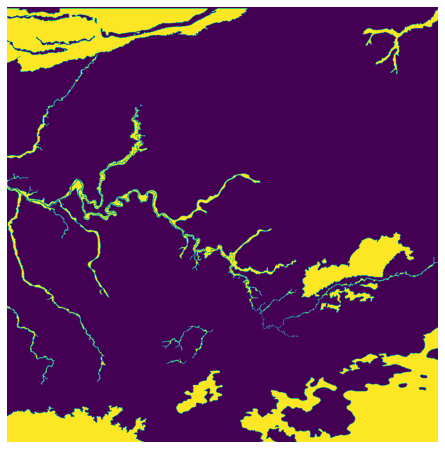

In [23]:
import rasterio
src = rasterio.open('RASTERS/rock_classes.tif')
rock_classes = src.read(1)
plt.figure(figsize=(8, 8))
plt.imshow(rock_classes, cmap='viridis', aspect=1)
plt.axis('off')
plt.show()

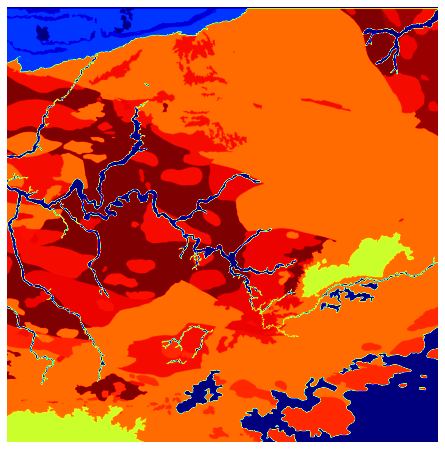

In [24]:
import rasterio
src = rasterio.open('RASTERS/idade_min.tif')
idade_min = src.read(1)
idade_min = np.where(idade_min == np.nan, 0, idade_min)
plt.figure(figsize=(8, 8))
plt.imshow(idade_min, cmap='jet', aspect=1)
plt.axis('off')
plt.show()

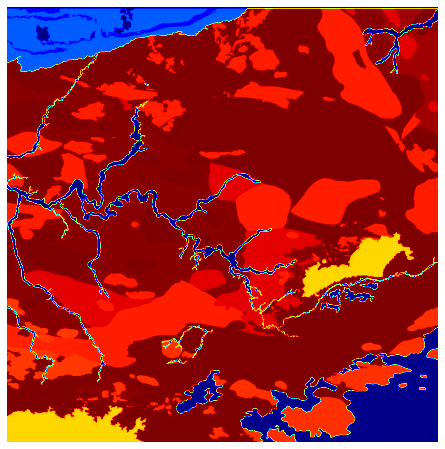

In [25]:
import rasterio
src = rasterio.open('RASTERS/idade_max.tif')
idade_max = src.read(1)
idade_max = np.where(idade_max == np.nan, 0, idade_max)
plt.figure(figsize=(8, 8))
plt.imshow(idade_max, cmap='jet', aspect=1)
plt.axis('off')
plt.show()

In [29]:
dset['litho_classes'] =  (['y', 'x'], np.flip(rock_classes, axis=0),
                                             {'0':'Not Sedimentary', '1':'Sedimentary'})
dset['idade_min'] =  (['y', 'x'], np.flip(idade_min, axis=0),
                                             {'unit':'Ma'})
dset['idade_max'] =  (['y', 'x'], np.flip(idade_max, axis=0),
                                             {'unit':'Ma'})
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 -55.49 -55.49 -55.49 ... -54.0 -54.0
    lat                    (y, x) float64 -11.0 -11.0 -11.0 ... -9.497 -9.497
Dimensions without coordinates: y, x
Data variables: (12/18)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 ...
    eTh                    (y, x) float64 ...
    eU                     (y, x) float64 ...
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    lineam_ne_sw_proxim    (y, x) float64 ...
    lineam_wnw_ese_proxim  (y, x) float64 ...
    pos_locations_buffer   (y, x) float64 38.24 38.13 38.02 ... 110.3 110.5
    litho_classes          (y, x) float32 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    idade_min              (y, x) float32 1.201e+03 1.201e+03 ... 0.0 0.0
    idade_max              (y, x) float32 1.4e+03 1.4e+03 1.4e+03 ... 0.0 0.0
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

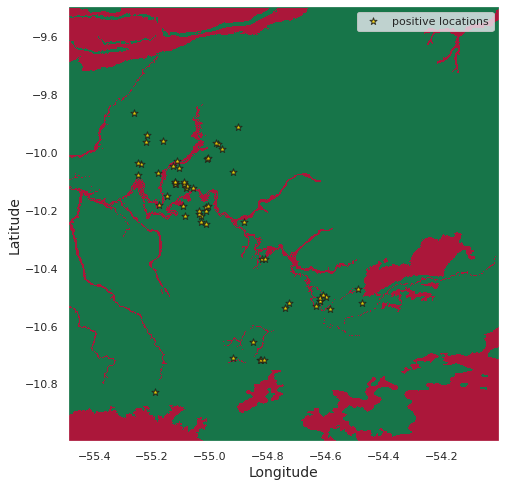

In [30]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='w')
ax.pcolormesh(dset['lon'].data, dset['lat'].data, dset['litho_classes'].data, shading='auto', cmap='RdYlGn_r', alpha=0.9)
# ax.pcolormesh(dset['lon'].data, dset['lat'].data, np.where(dset['pos_locations_buffer'].data > 10., np.nan, 1),
#                    shading='auto', cmap='Greys_r', vmin=0., vmax=1, alpha=0.6)
pos_gdf.plot(ax=ax, color='gold', edgecolor='k', alpha=0.85, label='positive locations', marker='*', markersize=55)
ax.set_aspect(1)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.legend()
#fig.savefig('figs/sedimentary_rocks_plus_buffer.png', dpi=400, bbox_inches='tight')
#fig.savefig('figs/sedimentary_rocks_plus_buffer.svg', format='svg', dpi=400, bbox_inches='tight')
plt.show()

### ML modelling

In [31]:
print('variables', variables)

variables ['TC', 'Kperc', 'eTh', 'eU', 'resmag', 'asa', 'tilt', 'DTM', 'litho_units', 'labels', 'fav_lithos', 'dykes_buffer', 'lineam_ne_sw_proxim', 'lineam_wnw_ese_proxim']


In [32]:
print('K min:', dset['Kperc'].data.min(), 'Th min:', dset['eTh'].data.min(), 'U min:', dset['eU'].data.min())

K min: -0.712264992389143 Th min: -2.4308982547122455 U min: -2.477627723767782


In [33]:
dset['Th_K'] =  (['y', 'x'], (dset['eTh'].data + 2.5)/(dset['Kperc'].data + 2.5),
                  {'variable':'eTh-Kperc ratio', 'unit':'dimensionless'})
dset['U_K'] = (['y', 'x'], (dset['eU'].data + 2.5)/(dset['Kperc'].data + 2.5),
                  {'variable':'eU-Kperc ratio', 'unit':'dimensionless'})
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 -55.49 -55.49 -55.49 ... -54.0 -54.0
    lat                    (y, x) float64 -11.0 -11.0 -11.0 ... -9.497 -9.497
Dimensions without coordinates: y, x
Data variables: (12/20)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 0.3964 0.3964 0.3964 ... 0.5725 0.5287
    eTh                    (y, x) float64 2.669 2.669 2.669 ... 5.193 5.544
    eU                     (y, x) float64 6.307 6.307 6.307 ... 20.07 19.75
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    pos_locations_buffer   (y, x) float64 38.24 38.13 38.02 ... 110.3 110.5
    litho_classes          (y, x) float32 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    idade_min              (y, x) float32 1.201e+03 1.201e+03 ... 0.0 0.0
    idade_max              (y, x) float32 1.4e+03 1.4e+03 1.4e+03 ... 0.0 0.0
    Th_K                   (y, x) float64 1.785 1.785 1.785 ... 2.504 2.656
    U_K                    (y, x) float64 3.041 3.041 3.041 ... 7.346 7.345
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

In [55]:
#save dataset to netcdf
dset.to_netcdf(path='DATASETS/dset_AF_4.nc', mode='w', format='NETCDF4')

In [34]:
variables = ['U_K', 'Th_K', 'DTM', 'dykes_buffer', 'lineam_wnw_ese_proxim', 'fav_lithos', 'idade_min', 'idade_max']
print(variables)

['U_K', 'Th_K', 'DTM', 'dykes_buffer', 'lineam_wnw_ese_proxim', 'fav_lithos', 'idade_min', 'idade_max']


In [35]:
def create_sets(ds, data, labels, buffer, y_index, x_index, features, dist=10., shuffle=True, specify=False, max_likelihood=0.5, use_only=False):
    
    from numpy import random, where, unique, concatenate, arange, ones, zeros
    
    set_array = np.empty((y_index.size, len(features)))

    for i in range(len(features)):
        set_array[:, i] = data[i][y_index, x_index]
        
        
    # positive locations' indexes
    labels = labels[y_index, x_index]
    pos_cond = (labels == 1) | (labels == 2)
    
    if use_only:
        pos_cond = labels == use_only
    pos_index = where(pos_cond)[0]
    
    # negative locations' indexes
    buffer_ = buffer[y_index, x_index]
    neg_index = random.choice(np.where(buffer_ > dist)[0], size=pos_index.size, replace=False)
    lat, lon = ds['lat'].data[y_index, x_index], ds['lon'].data[y_index, x_index]
    
    if specify:
        lat, lon = ds['lat'].data[y_index, x_index], ds['lon'].data[y_index, x_index]
        ny0, nx0 = unique(lat).size, unique(lon).size
        
        # negative locations' indexes
        spec_yx = where(ds[specify].data[y_index, x_index] < 1.)[0]
        dist_yx = where(buffer_ > dist)[0]
        neg_index = random.choice(np.intersect1d(spec_yx, dist_yx), size=pos_index.size, replace=False)
        
    
    # create sets
    pos_set = set_array[pos_index]
    neg_set = set_array[neg_index]
    
    # create labels
    pos_labels = ones(pos_index.size)
    neg_labels = zeros(neg_index.size)
    
    # concat
    X = concatenate((pos_set, neg_set))
    y = concatenate((pos_labels, neg_labels))
    
    if shuffle:
        idx = arange(y.size, dtype=int)
        random.shuffle(idx)
        
        X = X[idx]
        y = y[idx]
    
    
    return X, y, lat[neg_index], lon[neg_index]

In [36]:
data = np.array(dset[variables].to_array())
labels = dset['labels'].data
buffer = dset['pos_locations_buffer'].data

In [37]:
%time X_train, y_train, lat1, lon1 = create_sets(dset, data, labels, buffer, train_idk, train_idj, variables, use_only=False)
%time X_test_dep, y_test_dep, _, _ = create_sets(dset,data, labels, buffer, test_idk, test_idj, variables, use_only=2)
%time X_test, y_test, lat, lon = create_sets(dset, data, labels, buffer, test_idk, test_idj, variables,  use_only=False)

CPU times: user 102 ms, sys: 8.25 ms, total: 110 ms
Wall time: 107 ms
CPU times: user 86.1 ms, sys: 8.31 ms, total: 94.4 ms
Wall time: 94 ms
CPU times: user 87.1 ms, sys: 0 ns, total: 87.1 ms
Wall time: 86.9 ms


In [39]:
print(y_train.size, y_test_dep.size, y_test.size)

80 6 38


In [40]:
from sklearn.preprocessing import StandardScaler

# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [41]:
# create model
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

In [42]:
from sklearn.model_selection import RandomizedSearchCV

param_grid={'bootstrap':[False, True],
'criterion':['gini', 'entropy'],
 'max_depth': [2, 5, 10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'min_samples_split': [2, 3, 5, 10],
 'n_estimators': [400, 600, 800, 1000, 1200, 1400, 1600, 1800]}

grid_search = RandomizedSearchCV(rf_clf, param_grid, n_iter=50,
                          cv=5, n_jobs =-1, verbose=0, error_score=False, return_train_score=False)
search = grid_search.fit(X_train, y_train)

In [43]:
best_params = search.best_params_
print(f'the best params: {best_params}')

the best params: {'n_estimators': 1200, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'gini', 'bootstrap': False}


In [44]:
# reset & train the model

rf_clf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                min_samples_split=best_params['min_samples_split'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                max_features=best_params['max_features'], max_depth=best_params['max_depth'],
                                criterion=best_params['criterion'], bootstrap=best_params['bootstrap'], n_jobs=-1, random_state=13)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=2, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=3,
                       n_estimators=1200, n_jobs=-1, random_state=13)

In [45]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_auc_score

y_pred = rf_clf.predict(X_train)
acc = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
cf_matrix = confusion_matrix(y_train, y_pred)
auc = roc_auc_score(y_train, y_pred)

print(f'train - average metrics - accuracy: {acc:.3f}, recall: {recall:.3f}, f1_score: {f1:.3f}, AUC: {auc:.3f}')

y_pred = rf_clf.predict(X_test_dep)

acc = accuracy_score(y_test_dep, y_pred)
recall = recall_score(y_test_dep, y_pred)
f1 = f1_score(y_test_dep, y_pred)
cf_matrix = confusion_matrix(y_test_dep, y_pred)
auc = roc_auc_score(y_test_dep, y_pred)

print(f'test dep - average metrics - accuracy: {acc:.3f}, recall: {recall:.3f}, f1_score: {f1:.3f}, AUC: {auc:.3f}')

y_pred = rf_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cf_matrix = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f'test dep + occ - average metrics - accuracy: {acc:.3f}, recall: {recall:.3f}, f1_score: {f1:.3f}, AUC: {auc:.3f}')

train - average metrics - accuracy: 0.938, recall: 0.925, f1_score: 0.937, AUC: 0.937
test dep - average metrics - accuracy: 0.500, recall: 0.000, f1_score: 0.000, AUC: 0.500
test dep + occ - average metrics - accuracy: 0.763, recall: 0.842, f1_score: 0.780, AUC: 0.763


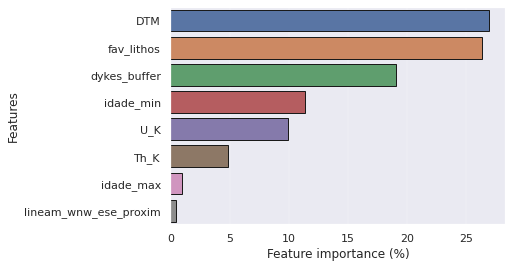

In [46]:
FI = rf_clf.feature_importances_
arg = np.argsort(rf_clf.feature_importances_)[::-1]
FI_dict = {'Features': np.array(variables)[arg], 'Feature importance (%)':FI[arg]*100}
FI_df = pd.DataFrame(FI_dict)

plt.figure(facecolor='w')
plt.grid(linewidth=0.2)
sns.barplot(y='Features', x='Feature importance (%)', data=FI_df, edgecolor='k')
plt.show()
#plt.savefig('figs/feat_importances.png', dpi=400, bbox_inches='tight')

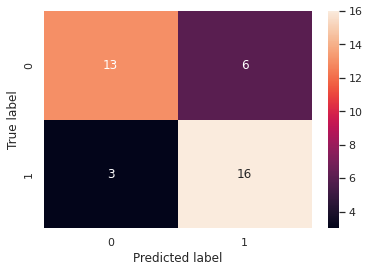

In [47]:
sns.heatmap(cf_matrix, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### SHAPley values

In [48]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [49]:
explainer = shap.TreeExplainer(rf_clf)
rf_shap_values = explainer.shap_values(X_train)

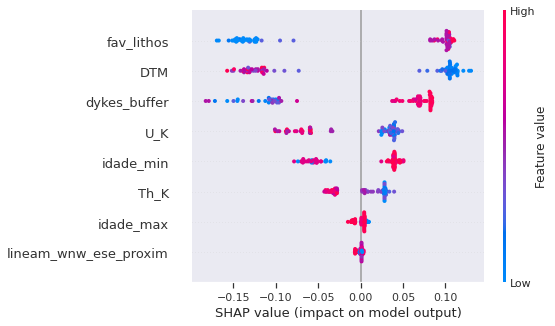

In [51]:
shap.summary_plot(rf_shap_values[1], X_train, variables)

### Predition

In [52]:
# predicting on the entire test dataset
data = np.array(dset[variables].to_array())
XX = np.empty((test_idk.size, len(variables)))
    
for i in range(len(variables)):
    XX[:, i] = data[i][test_idk, test_idj]
XX = scaler.fit_transform(XX)

In [53]:
# predicting classes probabilities
prob = rf_clf.predict_proba(XX)
prob = np.array(prob[:, 1])
prob = prob.reshape(ny1, nx1)

In [ ]:
prob = prob.reshape(ny1, nx1)
lon = dset['lon'].data[test_idk, test_idj].reshape(ny1, nx1)
lat = dset['lat'].data[test_idk, test_idj].reshape(ny1, nx1)

fig, ax = plt.subplots(figsize=(11, 9))
im = ax.pcolormesh(lon, lat, prob,
                   shading='auto', cmap='nipy_spectral', vmax=0.95)
pos_gdf.plot(ax=ax, color='gold', edgecolor='k', alpha=0.9, label='positive locations', marker='*', markersize=55)
plt.colorbar(im, ax=ax, label='Prospectivity', orientation='horizontal')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())
ax.set_aspect(1)
plt.legend()
plt.savefig('figs/mpm_gold_rf.png', dpi=400, bbox_inches='tight')
plt.show()

In [56]:
cond = (dset['labels'].data[test_idk, test_idj].reshape(ny1, nx1) == 1) | (dset['labels'].data[test_idk, test_idj].reshape(ny1, nx1) == 2)

# positive locations in the test area
ptk, ptj = np.where(cond)

In [57]:
def calc_props(prob, ptk, ptj):

    perc_area = []
    prop_pred_deps = []
    pos_prob = prob[ptk, ptj]

    for v in np.arange(0., 1.1, 0.1):
        perc_area.append(prob[prob >= v].size/prob.size)
        prop_pred_deps.append(pos_prob[pos_prob >= v].size/pos_prob.size)
    
    
    return np.array(perc_area), np.array(prop_pred_deps)

In [58]:
perc_area, prop_pred_deps = calc_props(prob, ptk, ptj)

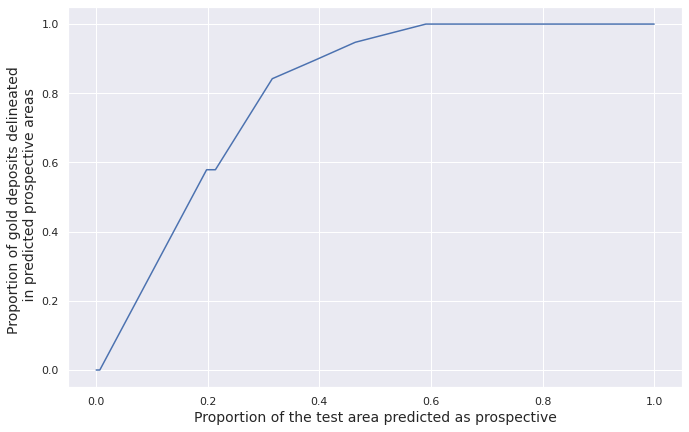

In [59]:
plt.figure(figsize=(11, 7))
plt.plot(perc_area, prop_pred_deps)
plt.ylabel('Proportion of gold deposits delineated \n in predicted prospective areas', fontsize=14)
plt.xlabel('Proportion of the test area predicted as prospective', fontsize=14)
plt.grid()
plt.show()